In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import skimage
from skimage.feature import canny
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, rotate
import math
from scipy import ndimage
from matplotlib.path import Path

smart content aware noise removal could be one idea to improve.
working fine all images.
gaussianblur inbuilt works only on even window sizes

In [2]:
def find_scan_screenshot(img):
    # return 0 for scan/screenshot and 1 for photograph
    total_pixels = img.shape[0]*img.shape[1]
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    prop = np.sum(hist[15:241])/total_pixels
    if prop<0.1:
        return 0
    else:
        return 1

In [3]:
def binarization_scans(img):
    # using inbuilt otsu's method..Implement later
    _,im = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return im
#handle very small images later 
def binarization_photos(img):
    high_res = 0
    if img.size>2000*1000:
        high_res = 1
    
    if high_res==1:
        img = cv2.GaussianBlur(img,(9,9),3) # fails for even
    
    window_size = int(min(img.shape[0],img.shape[1])/60)
    if window_size%2==0:
        window_size+=1 #cv2.adaptiveThreshold accepts only odd window sizes
    
    thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,window_size,10)
    return thresh_img

def morph_proc(img):
    img = 255 - img
    img[img==255] = 1
    kernel = np.ones((3,3))
    kernel1 = np.ones((5,5))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) 
    closed = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel) 
#     filled = cv2.morphologyEx(closed, cv2.MORPH_DILATE, kernel1) 
    fin_img = cv2.morphologyEx(closed, cv2.MORPH_DILATE, kernel1) 
#     hole_size = int(0.0005 * img.shape[0] * img.shape[1])
#     fin_img = remove_small_holes(fin_img, area_threshold=hole_size)
    fin_img[fin_img==1] = 255
    return 255 - fin_img

In [4]:
def binarize_input(img):
    img_type = find_scan_screenshot(img)
    if img_type==0:
        print("Scan/Screenshot")
    else:
        print("Photograph")
    if img_type==0:
        new_img = binarization_scans(img)
    else:
        new_img = binarization_photos(img)
        new_img = morph_proc(new_img)
    return new_img

In [5]:
def remove_small_noise(img):
    img[img==255] = 1
    hole_size = int(0.0005 * img.shape[0] * img.shape[1])
    new_img = remove_small_holes(img, area_threshold=hole_size)
    new_img[new_img==1] = 255
    return 255-new_img

In [6]:
# directory = "../input/"
# for filename in os.listdir("../input/"):
#     try:
#         img_name = os.path.join(directory, filename)
#         print(img_name)
#         img = cv2.imread(img_name,0)
#         plt.imshow(img,cmap='gray')
#         plt.show()
#         new_img = binarize_input(img)
#         plt.imshow(new_img,cmap='gray')
#         plt.show()
#     except :
#         pass
    
# remove very small images maybe based on area after connected comp analysis

In [18]:
def skew_correction(img):
    neg_img = 255 - img
#     print("skew_correction")
    
    img_edges = canny(neg_img, sigma=7)
#     plt.imshow(img_edges,cmap='gray')
#     plt.show()
    h, theta, d = hough_line(img_edges)
    h, theta, d = hough_line_peaks(h, theta, d, min_distance=0, min_angle=0, num_peaks=4)
    theta = [int(np.round(math.degrees(i))) for i in theta]    
    print(theta)

    dom_orient = max(theta)
    deskewing_angle = dom_orient - 90

    while abs(deskewing_angle) > 45: 
        deskewing_angle = deskewing_angle - (abs(deskewing_angle)/deskewing_angle) * 90

    print(deskewing_angle)
#     deskew_img = skimage.transform.rotate(neg_img, deskewing_angle, resize=True, cval=1, mode ='constant')
    deskew_img = skimage.transform.rotate(neg_img, deskewing_angle, mode='constant', cval=0, preserve_range=True, clip=True)
    
    deskew_img = 255-deskew_img
    return deskew_img.astype(np.uint8)

In [8]:
# directory = "../input/"
# for filename in os.listdir("../input/"):
#     try:
#         img_name = os.path.join(directory, filename)
#         img = cv2.imread(img_name,0)
#         plt.imshow(img,cmap="gray")
#         plt.show()
#         plt.imshow(skew_correction(binarize_input(img)),cmap="gray")
#         plt.show()
#     except:
#         pass
# img = cv2.imread("../input/eq5_hr.jpg",0)
# new_img = binarize_input(img)
# img_rotated = skew_correction(new_img)
# plt.imshow(im,cmap='gray')

In [9]:
# img = cv2.imread("../input/eq5_hr.jpg",0)
# plt.imshow(img,cmap='gray')
# plt.show()
# new_img = binarize_input(img)
# img_rotated = skew_correction(new_img)
# plt.imshow(img_rotated,cmap='gray')
# plt.show()

In [10]:
def check_contains(bbox1, bbox2): 
    '''check if bbox2 is contained in bbox1'''
    if (bbox1[0]<bbox2[0]) and (bbox1[2]>bbox2[2]) and (bbox1[1]<bbox2[1]) and (bbox1[3]>bbox2[3]):
        return True
    return False
    

In [43]:
def segmentation(im):
#     plt.imshow(im,cmap='gray')
#     plt.show()
    neg_im = 255-im
    kernel = np.ones((3,3), np.uint8) 
    neg_im_erosion = cv2.erode(neg_im, kernel, iterations=1) 
#     edge_map = np.logical_xor(neg_im,neg_im_erosion)
    edge_map = neg_im_erosion # change to above
    print('edge map')
    plt.imshow(edge_map,cmap="gray")
    plt.show()
    labels = skimage.measure.label(edge_map, connectivity=2) #connectivity-2 => neighbours 8
    reg = skimage.measure.regionprops(labels)
#     print(len(reg))
    bboxs = [i.bbox for i in reg] #min_row, min_col, max_row, max_col
    centroids = [i.centroid for i in reg]
    convex_hulls = [i.convex_image for i in reg]
    imgs = [i.image for i in reg]
    ign_ind = []
    # checking if bounding box is contained, need to change to, convex hull being contained - vivek
#     need to add additional check with edge map
    for i in range(0,len(bboxs)): #checks if 'j' is contained in 'i'
        for j in range(0,len(bboxs)):
            if bboxs[i]==bboxs[j]:
                continue
            
            contains = check_contains(bboxs[i],bboxs[j])
            if contains:
                ign_ind.append(j)
                
    
#     for i in ign_ind:
#         print(bboxs[i])
#         plt.imshow(im[bboxs[i][0]:bboxs[i][2],bboxs[i][1]:bboxs[i][3]],cmap='gray')
#         plt.show()
#     plt.imshow(imgs[i],cmap=plt.cm.gnuplot)
    centroids_new = []
    bboxs_new = []
    convex_hulls_new = []
    imgs_new = []
    imgs_sizes = []
    for i in range(0,len(imgs)):
        if i in ign_ind:
#             print(i,"hai")
            continue
        elif imgs[i].size<1000: #theshold of 1000 on segmented part sizes to get rid of extra noisy stuff
            continue
        centroids_new.append(centroids[i])
        bboxs_new.append(bboxs[i])
        convex_hulls_new.append(convex_hulls[i])
        imgs_new.append(imgs[i])
        imgs_sizes.append(imgs[i].size)
#         plt.imshow(imgs[i],cmap="gray")
#         plt.show()
    
    imgs_sizes = np.sort(imgs_sizes)
    print(imgs_sizes)
    return centroids_new, bboxs_new, convex_hulls_new, imgs_new

In [12]:
# img = cv2.imread("../input/eq5_hr.jpg",0)
# plt.imshow(img,cmap='gray')
# plt.show()
# new_img = binarize_input(img)
# img_rotated = skew_correction(new_img)
# plt.imshow(img_rotated,cmap='gray')
# plt.show()
# centroids, bboxs, convex_hulls,imgs = segmentation(img_rotated)
# centroids_new = []
# for i in range(0, len(imgs)):
#     plt.imshow(imgs[i],cmap='gray')
#     centrs = [centroids[i][0],centroids[i][1]]
#     centrs[0]-=bboxs[i][0]
#     centrs[1]-=bboxs[i][1]
#     print(centrs)
#     centroids_new.append(centrs)
#     plt.show()

In [62]:
def create_identifier(img,centroid):
#     print("maxi:",np.max(img))
#     img = ~img
#     plt.imshow(img,cmap='gray')
#     plt.show()
    #assuming that the character pixels in the paper means those pixels belonging to character
    id_profile = np.zeros(22)
    mom_inertia = 0
    char_count = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if img[i,j] != 0:
                char_count+=1
                mom_inertia+=(i-centroid[0])**2+(j-centroid[1])**2
    mom_inertia/=(char_count**2)
    id_profile[0] = mom_inertia
    img[img==255] = 1
    mu00 = central_moments(img,0,0)
    etas = np.zeros((4,4))
    for p in range(0,4):
        for q in range(0,4):
            if p+q<=3:
                gamma = 1 + (p+q)/2
                etas[p,q] = central_moments(img,p,q)/(mu00**gamma)

    hu2 = (etas[2,0] - etas[0,2])**2 + (4*etas[1,1]**2)
    hu3 = (etas[3,0] - 3*etas[1,2])**2 + (3*etas[2,1] - etas[0,3])**2
    hu4 = (etas[3,0] + etas[1,2])**2 + (etas[2,0] + etas[0,3])**2
    hu5 = (etas[3,0] - 3*etas[1,2])*(etas[3,0] + etas[1,2])*((etas[3,0] + etas[1,2])**2 - 3*((etas[2,1] + etas[0,3])**2)) + (3*(etas[2,1] - etas[0,3]))*(etas[2,1] + etas[0,3])*(3*(etas[3,0] + etas[1,2])**2 - (etas[2,1] + etas[0,3])**2)
    hu6 = (etas[2,0] - etas[0,2])*((etas[3,0]+etas[1,2])**2 - (etas[2,1]+ etas[0,3])**2) + 4*etas[1,1]*((etas[3,0] + etas[1,2])*(etas[2,1] + etas[0,3]))
    hu7 = (3*etas[2,1] - etas[0,3])*(etas[3,0] + etas[1,2])*((etas[3,0] + etas[1,2])**2 - 3*(etas[2,1]-etas[0,3])**2) - (etas[3,0] - 3*etas[1,2])*(etas[2,1] + etas[0,3])*(3*(etas[3,0] + etas[1,2])**2 - (etas[2,1] + etas[0,3])**2)
    id_profile[16] = hu2
    id_profile[17] = hu3
    id_profile[18] = hu4
    id_profile[19] = hu5
    id_profile[20] = hu6
    id_profile[21] = hu7
    id_profile[1:16] = get_circular_topology(img,centroid)
    return id_profile

In [53]:
def central_moments(img, p, q):
    img[img==255] = 1
    M00 = 0 
    M10 = 0
    M01 = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            M00+=img[i,j]
            M10+=i*img[i,j]
            M01+=j*img[i,j]
    
    x_bar = np.floor(float(M10)/float(M00))
    y_bar = np.floor(float(M01)/float(M00))
    
    cen_mmt = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            cen_mmt += ((i-x_bar)**p)*((j-y_bar)**q)*img[i,j]
            
    return cen_mmt

In [52]:
def create_new_centroids(centroids,bboxs,ims):
    centroids_new = []
    for i in range(0, len(ims)):
        plt.imshow(ims[i],cmap='gray')
        centrs = [centroids[i][0],centroids[i][1]]
        centrs[0]-=bboxs[i][0]
        centrs[1]-=bboxs[i][1]
        print(centrs)
        centroids_new.append(centrs)
        plt.show()
    return centroids_new

In [69]:
def ang_dist(xx,yy):
    lis = [] 
    for x,y in zip(xx,yy):
        delta = np.abs(x-y)
        if delta > np.pi:
            delta = 2*np.pi-delta 
        lis.append(delta)
    return max(lis)
def circular_mask(img,centroid,radius):
    lastx,lasty = -10,-10
    last = 0
    count = 0
    cut_angles = []
    img = img.astype(np.uint8)
    angle = np.linspace(0,2*np.pi,3600)
    circle_x = np.rint(centroid[0]+radius*np.cos(angle)).astype(np.int64)
    circle_y = np.rint(centroid[1]+radius*np.sin(angle)).astype(np.int64)  
    for x,y,theta in zip(circle_x,circle_y,angle):
        if (x>=0 and x<img.shape[0] and y>=0  and y<img.shape[1]) == False:
            continue
        if img[x,y] != last :
            last = img[x,y]
            if img[x,y] == 1 and abs(lastx-x)+abs(lasty-y)>15:
                count += 1
                lastx,lasty = x,y
                cut_angles.append(theta)
                print(x,y)
    if count == 0:
        return 0,0
    cut_angles = np.asarray(cut_angles)
    angular_distance = ang_dist(np.roll(cut_angles,1),cut_angles)
    cv2.circle(img,(int(centroid[1]),int(centroid[0])),int(radius),1,thickness=1)
    plt.imshow(img,cmap="gray")
    plt.show()
    print(count)
    return count,angular_distance/(2*np.pi)
def get_circular_topology(img,centroid):
    circular_topology = np.zeros(16)
    #finding maximum distance
    edge_indices = np.argwhere(img)
    d=np.sqrt(np.max(np.sum((edge_indices-centroid)**2,axis=1)))/9
    for i in range(1,9):
        circular_topology[i-1],circular_topology[7+i] = circular_mask(img,centroid,i*d)
    return circular_topology[:-1]

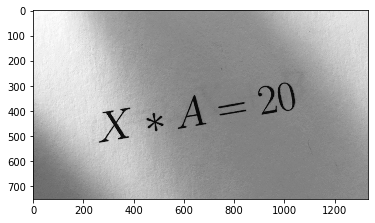

Photograph
[81, 80, 81, -15]
-9


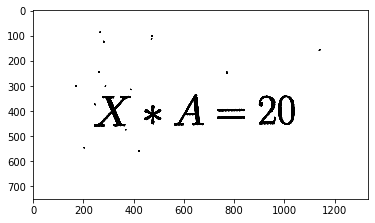

edge map


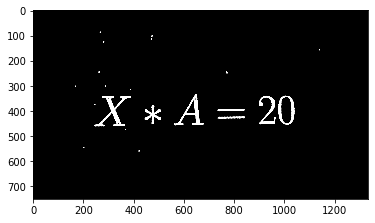

[ 1070  4950  7571  7590 14508 17520]
[73.60601163542339, 71.19295410471886]


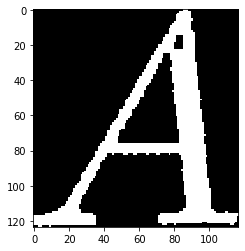

[57.18203982121088, 32.635107679804946]


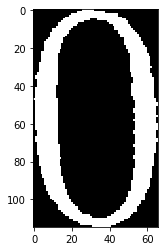

[59.291463954002666, 35.74966828836796]


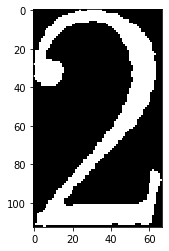

[59.76951092611864, 75.45941727367324]


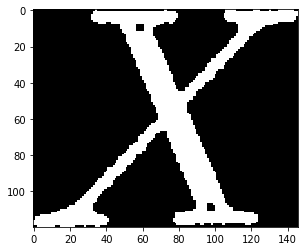

[36.52916666666664, 32.44940476190476]


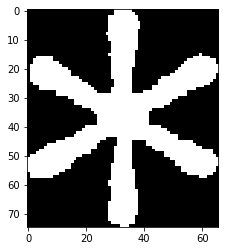

[4.429667519181578, 52.02046035805631]


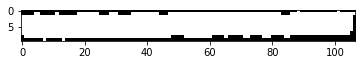

82 77
76 62


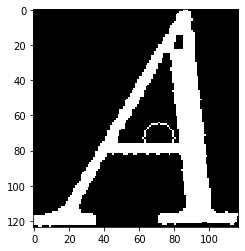

2
87 85
76 52


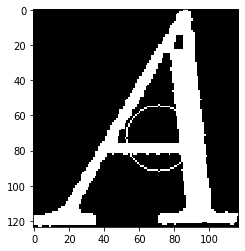

2
98 86
83 98
58 95
46 62
66 44


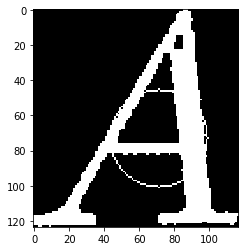

5
109 87
43 93
35 69
84 34


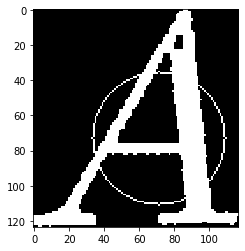

4
121 71
31 92
26 73
93 28
121 71


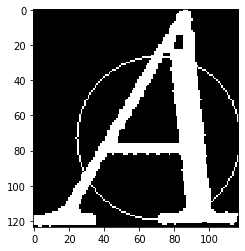

5
121 103
20 91
104 22
116 32


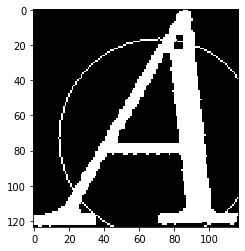

4
9 89
112 16


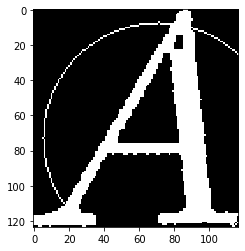

2
116 7


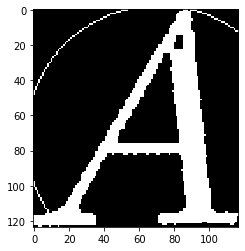

1
[ 6.06782623e-01  2.00000000e+00  2.00000000e+00  5.00000000e+00
  4.00000000e+00  5.00000000e+00  4.00000000e+00  2.00000000e+00
  1.00000000e+00  3.11753265e-01  3.56487913e-01  3.78438455e-01
  3.35370936e-01  4.26785218e-01  3.94831898e-01  3.89830508e-01
  5.32633722e-02  1.46026977e-01  8.34444587e-02  4.80207428e-04
  7.45683232e-04 -1.60441935e-04]


In [72]:
img = cv2.imread("../input/eq2_hr.jpg",0)
plt.imshow(img,cmap='gray')
plt.show()
new_img = binarize_input(img)
img_rotated = skew_correction(new_img)
plt.imshow(img_rotated,cmap='gray')
plt.show()
centroids, bboxs, convex_hulls,imgs = segmentation(img_rotated)
centroids_new = create_new_centroids(centroids, bboxs, imgs)
prof = create_identifier(imgs[0],centroids_new[0])
print(prof)

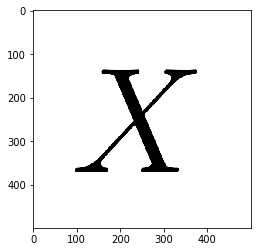

Scan/Screenshot


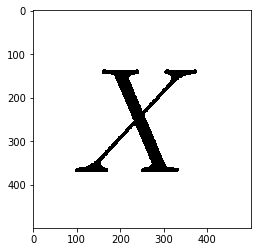

edge map


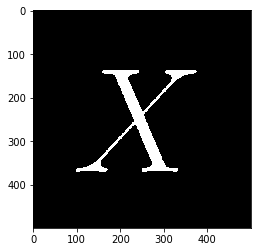

[65052]
[116.69969554386935, 144.42300950272164]


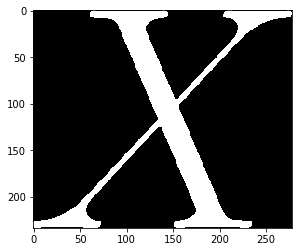

[[116.69969554386935, 144.42300950272164]]
137 144
100 157
126 126
137 143


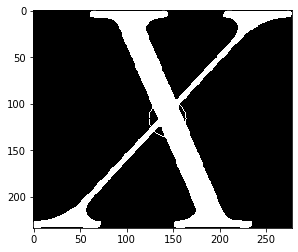

4
157 151
85 171
76 144
141 112


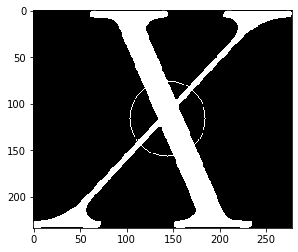

4
176 159
70 185
56 135
157 97


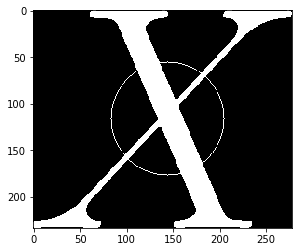

4
195 168
55 199
37 127
171 83


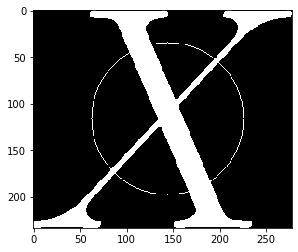

4
215 175
40 213
17 120
186 69


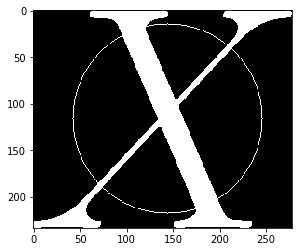

4
232 187
26 227
1 103
201 55


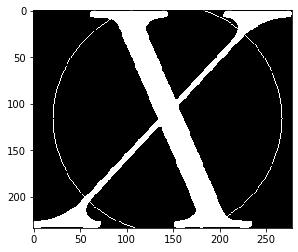

4
233 228
14 245
215 39


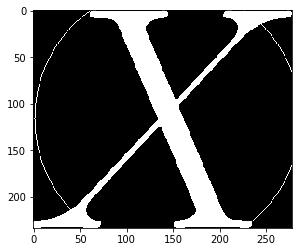

3
8 268
224 20


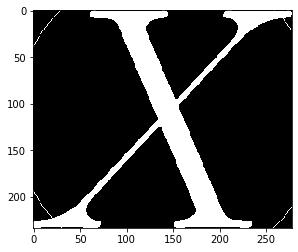

2
[ 8.64195935e-01  4.00000000e+00  4.00000000e+00  4.00000000e+00
  4.00000000e+00  4.00000000e+00  4.00000000e+00  3.00000000e+00
  2.00000000e+00  4.25673798e-01  3.63712142e-01  3.46485135e-01
  3.38427341e-01  3.35648791e-01  3.26757433e-01  4.93192553e-01
  1.19101458e-01  9.47624257e-03  3.20880501e-01 -8.45530543e-06
  7.01169534e-04 -1.37982765e-05]


In [71]:
plt.imshow(char_pal[1200:1700,3500:4000],cmap='gray')
plt.show()
A_pal = char_pal[1200:1700,3500:4000]
cv2.imwrite('../input/X.jpg',A_pal)
new_img_pal = binarize_input(A_pal)
plt.imshow(new_img_pal,cmap='gray')
plt.show()
centroids, bboxs, convex_hulls,imgs = segmentation(new_img_pal)
centroids_new = create_new_centroids(centroids, bboxs, imgs)
print(centroids_new)
prof = create_identifier(imgs[0],centroids_new[0])
print(prof)

[73.60601163542339, 71.19295410471886]

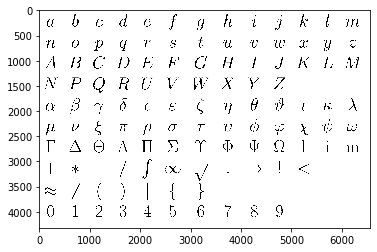

In [73]:
char_pal = cv2.imread("../input/reduced_characterPalette.jpg",0)
plt.imshow(char_pal,cmap='gray')
centroids_new[0]